# Python: merger simulations

In this notebook we introduce a simple model to do merger simulations. The analysis here is based on [Epstein and Rubinfeld (2001)](http://scholarship.law.berkeley.edu/cgi/viewcontent.cgi?article=2362&context=facpubs). 

The advantage of this approach is that the model can be calibrated with relatively little information. In particular, we need to know 

* the market shares of the firms in the relevant market,
* elasticity of market demand,
* own price elasticity for one firm and
* efficiency gains (claimed by firms).

Once, we know these things, we can simulate the market outcome before and after the merger. If we do not know one or more parameters, we can do sensitivity analysis: simply let the parameter run over a vector of values.



## what is the use of merger simulation?

Merger simulation is not a crystal ball! Economists cannot predict the future. By applying a model to the data that we have, we can think about the problem (effects of the merger, in this case) in a more structured way. In particular, we can think about the merger in a way that others can replicate. 

However, every model makes assumptions and if these assumptions do not apply, the outcome of the model will be incorrect. In other words, the predictions of the model need to be handled with care.

The model that we use here, makes the following assumptions:

* (P) Proportionality: if a firm raises its price, it loses market share; this lost market share is allocated to the other firms in the industry proportionally to these firms' market shares
* (H) Homogeneity: if all firms in the market raise their price by the same percentage, market shares are unaffected
* (A) Adding-up: market shares of all firms (brands) in the market add up to 1.

Although these assumptions are not unreasonable, they are not "innocent" either.




In [ ]:
First, we import some libraries that we will use:

In [1]:
from scipy import optimize,arange
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

## demand

In this notebook we assume that there are 3 firms in the market, named "firm_1, firm_2, firm_3". If you use this noetbook for a real case, make sure you call the firms by their name, like "microsoft, google, facebook" etc. This makes the code more readable than working with firms 1,2,3 and forcing the reader at each step to remember that firm 1 was supposed to be microsoft.

The market share of firm $i$ is defined as $s_i = \frac{p_i q_i}{P Q}$, where $p_i$ denotes $i$'s price, $q_i$ its quantity, $Q$ total output on the market and $P$ the aggregate industry price index. We assume that this price index is given by $P=\sum_{i=1}^3 s_i \ln(p_i)$. 

Firm $i$'s demand in this model is written in terms of its market share: $s_i = a_i + b_{ii} \ln(p_i) + b_{ij} \ln(p_j) + b_{ik} \ln(p_k)$.



## calibration

Although this demand structure is a bit unusual, it has the following useful property. 

In [2]:
def demand(x1,x2,b):
    return 1-x1-b*x2

def cost(x,c):
    if x == 0:
     cost = 0
    else:
     cost = c*x
    return cost

## profits

With demand and costs, we can define profits as 
$$
\pi(x_i,x_j) = p_i(x_i,x_j)x_i-c(x_i)
$$


In [3]:
def profit(x1,x2,c1,b):
    return demand(x1,x2,b)*x1-cost(x1,c1)

## reaction functions

Under Cournot competition, firm $i$ chooses $x_i$ to maximize profits, taking $x_2$ as given. That is, $x_1^*,x_2^*$ is a Nash equilibrium if and only if

$$
x_i^* = \arg\max_{x_i} \pi(x_i,x_j^*)
$$

for each $i \neq j \in \{1,2\}$. 

Hence, we first determine what the optimal output level of one firm is, given the choice $x_2$ of the other firm. The function `reaction` does exactly that. When we do this in an exercise, we take the first order condition. That is, we calculate the Nash equilibrium as the solution $x_1^*,x_2^*$ to 

$$
\left. \frac{\partial \pi(x_i,x_j)}{\partial x_i} \right|_{x_i=x_i^*,x_j=x_j^*} = 0
$$

provided that $\pi$ is concave in $x_i$. So one way to go is to let Python calculate the derivative and solve this equation for each firm. However, Python (in particular, the scipy-library) can also directly look for the profit maximizing outcome. Below we use the function `brute` to look for the global maximum of $\pi$. In principle, the first derivative may give us a local maximum but not the global one. In particular, if $f>0$ it may be the case that $x_i^*=0$ (one firm is not active), while the first order condition gives $x_i^* >0$ (but with negative profits).

The [scipy optimize](http://docs.scipy.org/doc/scipy-0.14.0/reference/optimize.html) library has a number of routines to optimize functions. They are all defined as minimization problems. So if we want to maximize a function $f(x)$, we need to minimize $-f(x)$. 

In [1]:
def reaction(x2,c1,b):
    x1 = optimize.brute(lambda x: -profit(x,x2,c1,b), ((0,1,),)) # brute minimizes the function;
                                                                 # when we minimize -profits, we maximize profits
    return x1[0]

## equilibrium as fixed point

To find an equilibrium, we are looking for a (so called) fixed point. That is, we have a function $f(x)$ and look for the point where $x = f(x)$. In this case, $x$ and $f$ are two dimensional vectors. 

Let $r_i(x_j)$ denote firm $i$'s optimal response to $j$'s output level $x_j$. Then we need to find a point such that

$$
\pmatrix{x_1^* \\ x_2^*} = \pmatrix{r_1(x_2^*) \\ r_2(x_1^*)}
$$

Defining the vector function $f(x_1,x_2)$ as

$$
f(x) = \pmatrix{r_1(x_2^*) \\ r_2(x_1^*)}
$$

we are looking for a point $x^*=(x_1^*,x_2^*)$ such that $x^*=f(x^*)$.

The function `vector_reaction` is defined as $x-f(x)$ in this notation. Hence, to find the fixed point, we are looking for $x^*$ such that `vector_reaction` $= 0$; or put differently, $x^*-f(x^*)=0$.

We pass $b,c_1,c_2$ as a vector of parameters `param` $= [b, c_1, c_2]$.

In [5]:
def vector_reaction(x,param): # vector param = (b,c1,c2)
    return array(x)-array([reaction(x[1],param[1],param[0]),reaction(x[0],param[2],param[0])])

## Cournot equilibrium

Let's calulate the Cournot equilibrium in case both firms have zero costs ($c=0$) and they produce homogeneous goods ($b=1$). We use the routine `fsolve` (again from `scipy.optimize`) to find $x$ where `vector_reaction` $=0$. That is, `fsolve` finds the point of a function where it equals 0. We need to give `fsolve` an initial guess $x_0$. Further, we pass the paramter vector `param` as arguments (`args`) to `fsolve`.

In [6]:
param = [1.0,0.0,0.0]
x0 = [0.3, 0.3]

ans = optimize.fsolve(vector_reaction, x0, args = (param))
print ans

[ 0.33332648  0.33332648]


The variable `ans` contains the values of $x_1,x_2$ for which `vector_reaction` $=0$. 

You can see that we are dealing with numerical procedures here. 

* What is the Cournot equilibrium exactly in this case? Although what we find is (very) close, it is not exact!

We denote the symmetric Cournot equilibrium by $x^*$.

## collusion

We want to understand what the industry profits are if the firms collude on output levels $x_1,x_2$. To simplify, we focus on the case where firms are symmetric $c_1 = c_2 =c$. Further, the firms collude on symmetric output $x_1=x_2=x$. We plot industry profits $\pi(x,x)+\pi(x,x)=2\pi(x,x)$ as a function of $x$, where we check whether $x$ can be sustained under collusion. 

As we saw in the lecture, the condition for $x$ to be sustained as a collusive outcome is given by

$$
\pi(x,x) \frac{1}{1-\delta} \geq \max_{\hat x} \pi(\hat x,x) + \frac{\delta}{1-\delta} \pi(x^*,x^*) 
$$

where $\delta \in [0,1]$ denotes the discount factor, $x^*$ denotes the Nash equilibrium output level and $\hat x$ denotes the firm's optimal response to its opponent choosing output level $x$.

* Check that we can rewrite this inequality as:

$$
\pi(x,x) \geq (1-\delta) \max_{\hat x} \pi(\hat x,x) + \delta \pi(x^*,x^*) 
$$

* Check that $x=x^*$ satisfies this inequality. What is the interpretation of this?

Hence the function `collusion_profits` can be defined as follows:

In [7]:
def collusion_profits(x,b,c,delta): # we only do this for the symmetric case: c1 = c2 = c
    profits = profit(x,x,c,b)
    ans = optimize.fsolve(vector_reaction, x0, args = ([b,c,c]))
    if profits >= (1-delta)*profit(reaction(x,c,b),x,c,b)+delta*profit(ans[0],ans[1],c,b):
        industry_profits = 2*profits # profits can be sustained as collusion profits
    else:
        industry_profits = 0 # profits cannot be sustained as collusion profits
    return industry_profits


Note that profits $=0$ when collusion cannot be sustained. This is just to signal (in the graph) where collusion breaks down. It is not a prediction of the collusion profits. Indeed, if parties collude, they will choose $x$ to maximize their profits.

The next graph shows collusion profits for the case where $b=1.0,c_1=c_2=0.0$ and two values for $\delta$. 

* When $\delta$ is high enough (0.8 in this case), for which $x$ are profits maximized? 
* What is the interpretation of this $x$?

When $\delta$ is low (0.3), collusion profits are lower (and output is higher).

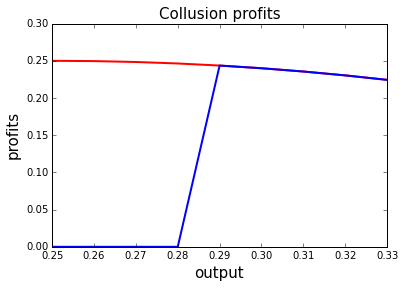

In [12]:
range_x = arange(0.25,ans[0],0.01)
delta1 = 0.8
delta2 = 0.3
range_profits = [collusion_profits(x,1.0,0.0,delta1) for x in range_x]
range_profits2 = [collusion_profits(x,1.0,0.0,delta2) for x in range_x]

plt.clf()
 
plt.plot(range_x, range_profits,'-', color = 'r', linewidth = 2)
plt.plot(range_x, range_profits2,'-', color = 'b', linewidth = 2)
plt.title("Collusion profits",fontsize = 15)
plt.xlabel("output",fontsize = 15)
plt.ylabel("profits",fontsize = 15,rotation = 90)
plt.xlim(0.25,0.33)
plt.ylim(0.0,0.3)
plt.savefig('collusion.png')

## imperfect substitutes

Exercise: plot profits for the case where $b = 0.5$, that is goods are imperfect substitutes.

* Why are collusion profits maximized for higher $x$ in this case?